# Data inspector

## 0. Imports

In [13]:
#To be at project directory root and not in the Notebooks folder
%cd /storage2/mwildi/CBS2

#Imports
import lmdb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
import random
from collections import Counter
import cv2
import math
import glob
from matplotlib.patches import Circle

/storage2/mwildi/CBS2


## 1. Read dataset

In [14]:
dataset_path = "dataset/test/main"
repetitions = [x[0] for x in os.walk(dataset_path)][1:]
print('Found {} repetitions'.format(len(repetitions)))
print(repetitions)

Found 71 repetitions
['dataset/test/main/guwuqgzssi', 'dataset/test/main/ivotcppxrx', 'dataset/test/main/gvwsosqqom', 'dataset/test/main/mkwxkoimcr', 'dataset/test/main/fxrjwxcsrb', 'dataset/test/main/tjyyhomypr', 'dataset/test/main/gnulggjvzp', 'dataset/test/main/qjmshhrztm', 'dataset/test/main/xrevpdapiv', 'dataset/test/main/rlrbcocdpj', 'dataset/test/main/bubsqdqrfo', 'dataset/test/main/smheaxfpih', 'dataset/test/main/elecvdclec', 'dataset/test/main/iohmldeqmd', 'dataset/test/main/aqyovvzbir', 'dataset/test/main/qystyedokx', 'dataset/test/main/nfyeerojkx', 'dataset/test/main/yenkdomgmw', 'dataset/test/main/sdikyelsuu', 'dataset/test/main/thzcfdwaoy', 'dataset/test/main/swhsgcwuif', 'dataset/test/main/lvhhgdttkx', 'dataset/test/main/swxobpvbos', 'dataset/test/main/ahllfysgvj', 'dataset/test/main/twrozbskbv', 'dataset/test/main/yditcqgqeg', 'dataset/test/main/setvhwtnfl', 'dataset/test/main/wndgkaekjp', 'dataset/test/main/rsevkwghlt', 'dataset/test/main/pvpfztiwqp', 'dataset/test/main

### 1.1 Decode dataset

In [37]:
def decode_dataset(path):
    lmdb_env = lmdb.open(path)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()

    out = dict()
    for key, value in tqdm(lmdb_cursor):
        out[key.decode("utf-8")] = value

    lmdb_cursor.close()
    return out

def decode_step_data(step_data, kind):
    if kind == 'tls':
        return np.frombuffer(step_data, dtype=np.uint8)
    if kind == 'lbl':
        lbl = np.frombuffer(step_data, dtype=np.uint8)
        lbl = lbl.reshape((96, 96, -1))
        return lbl
    elif kind.find('wide_rgb') != -1:
        img = np.frombuffer(step_data, dtype=np.uint8)
        img = img.reshape((240, 480, -1))
        return img
    elif kind.find('narr_rgb') != -1:
        img = np.frombuffer(step_data, dtype=np.uint8)
        img = img.reshape((240, 384, -1))
        return img
    elif kind.find('wide_sem') != -1:
        img = np.frombuffer(step_data, dtype=np.uint8)
        img = img.reshape((240, 480))
        return img
    else:
        return np.frombuffer(step_data, dtype=np.float32)
    
data_dict_base = {'lbl':None, 'loc':None, 'rot': None, 'spd':None, 'cmd':None, 'wide_rgb_0':None, 'narr_rgb_0':None, 'tls':None, 'wide_sem_0':None, 'ego_location':None, 'ego_rotation':None, 'cam_location':None, 'cam_rotation':None}      
def decode_step(dataset, step):
    data = data_dict_base
    for t in data.keys():
        d = dataset["{}_{:05d}".format(t, step)]
        data[t] = decode_step_data(d, kind=t)
    return data

In [38]:
rep = decode_dataset(repetitions[21])
total_frames = math.floor(len(rep)/(len(data_dict_base.keys())+2))
print(f'{total_frames} frames found')

15009it [00:00, 68500.73it/s]

1000 frames found


[300.586      199.61287      0.03335804]
tensor([[300.5860, 199.6129]])
tensor([[949.7580, 646.8386]])


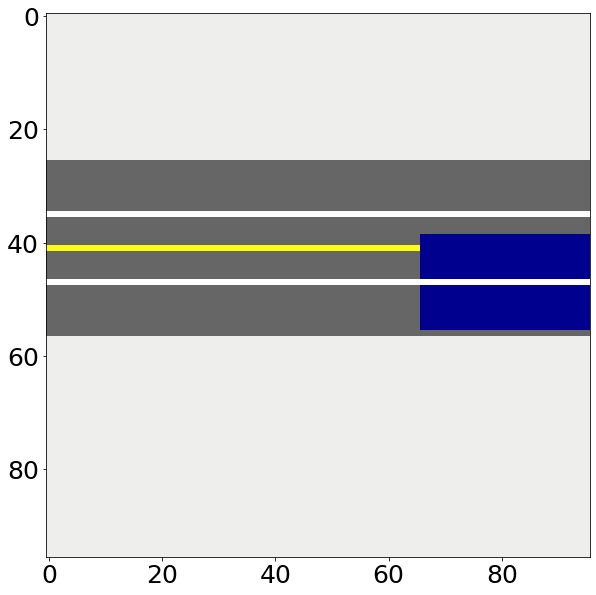

In [110]:
import worconverter
import image_utils
import torch
import importlib
importlib.reload(worconverter)
importlib.reload(image_utils)

step_data = decode_step(dataset=rep, step=40)
lbl=step_data['lbl']
cam_pos = step_data['cam_location']
cam_rot = step_data['cam_rotation']
rgb = step_data['wide_rgb_0']
loc=step_data['loc']
print(loc)

conv= worconverter.Converter(offset=6.0, scale=[1.5, 1.5]).to('cpu')
sensor_transform = Transform(Location(cam_pos[0], cam_pos[1], cam_pos[2]), Rotation(cam_rot[0], cam_rot[1], cam_rot[2]))
convcbs = image_utils.CoordinateConverter(sensor_transform, fov=120)

fbev, axbev = plt.subplots(figsize=(10,10))
#axbev.imshow(viz_obs(rgb, rot[1], spd, cmd=int(cmd), lbl=lbl, tls=tls))
axbev.imshow(viz_bv(lbl))
loctorch = torch.tensor([loc[:2]])
print(loctorch)

loc_bv = conv.world_to_map(loctorch)
#loc_bv= torch.tensor([[50,30]])
print(loc_bv)
for i in range(loc_bv.shape[0]):   
    axbev.add_patch(Circle(loc_bv[i], 1, facecolor=(0,1,0,3/(i+3))))

tensor([[949.7580, 646.8386]])
tensor([[337.3335, 121.2412]])


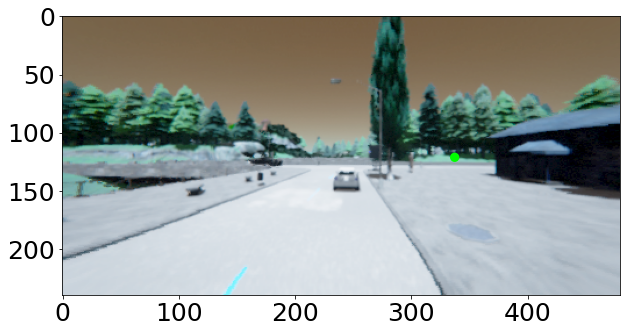

In [111]:
frgb, axrgb = plt.subplots(figsize=(10,10))
#axbev.imshow(viz_obs(rgb, rot[1], spd, cmd=int(cmd), lbl=lbl, tls=tls))
axrgb.imshow(rgb)
print(loc_bv)
loc_rgb = conv.map_to_cam(loc_bv)
loc_rgb_direct = conv.world_to_cam(loctorch)
print(loc_rgb)
#image_coords = convcbs.convert(np.array([[loc[0], loc[1], loc[2]]]))
#print(image_coords)
    
for i in range(loc_rgb.shape[0]):   
    axrgb.add_patch(Circle(loc_rgb[i], 4, facecolor=(0,1,0,3/(i+3))))

In [112]:
loc_world = conv.cam_to_world(loc_rgb)
print(loc_world)

tensor([[52.6632, 41.2930]])


tensor([[205.9897, 171.8790]])


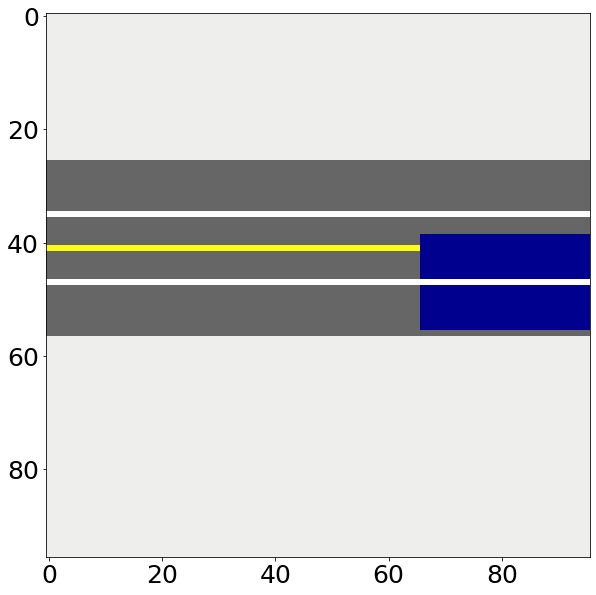

In [113]:
fbev, axbev = plt.subplots(figsize=(10,10))
axbev.imshow(viz_bv(lbl))
locs_bv2 = conv.world_to_map(loc_world)
print(locs_bv2)
for i in range(locs_bv2.shape[0]):   
    axbev.add_patch(Circle(locs_bv2[i], 1, facecolor=(0,1,0,3/(i+3))))

In [114]:

print(step_data['rot'])
step_data['ego_rotation']

[-3.7514966]


array([ 0.00711023, -3.7514966 , -0.11843871], dtype=float32)

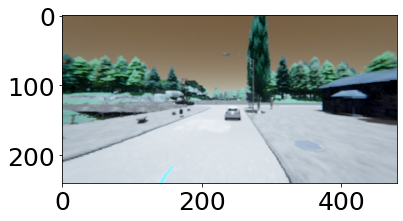

In [115]:
plt.imshow(step_data['wide_rgb_0'])

## 2. Waypoints computation

### 2.1 Tools for transformations

In [116]:
class Location():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def __repr__(self,):
        return self.__str__()

    def __str__(self,):
        return "Location(x={}, y={}, z={})".format(self.x, self.y, self.z)

class Rotation():
    def __init__(self, p, y, r):
        self.pitch = p
        self.yaw = y
        self.roll = r

    def __repr__(self,):
        return self.__str__()

    def __str__(self):
        return "Rotation(pitch={}, yaw={}, roll={})".format(self.pitch, self.yaw, self.roll)

class Transform():
    def __init__(self, loc, rot):
        self.location = loc
        self.rotation = rot

    def __repr__(self,):
        return self.__str__()

    def __str__(self,):
        return "Transform({}, {})".format(self.location, self.rotation)

In [117]:
PIXELS_PER_METER = 4
PIXELS_AHEAD_VEHICLE = 80

BACKGROUND = [238, 238, 236]

COLORS = [
        (102, 102, 102),
        (253, 253, 17),
        (255, 64, 64),
        (204, 6, 5),
        (0, 0, 142),
        (220, 20, 60),
        (255,0,0),
        (0,255,0),
        (0,0,0),
        (255,255,255),
        (0,255,128),
        (0,128,255),
        ]

SEM_COLORS = {
    4 : (220, 20, 60),
    5 : (153, 153, 153),
    6 : (157, 234, 50),
    7 : (128, 64, 128),
    8 : (244, 35, 232),
    10: (0, 0, 142),
    18: (220, 220, 0),
}

def viz_bv(birdview, no_show=[], num_channels=10):
    h, w = birdview.shape[:2]
    canvas = np.zeros((h, w, 3), dtype=np.uint8)
    canvas[...] = BACKGROUND

    for i in range(num_channels):
        if i in no_show:
            continue
        canvas[birdview[:,:,i] > 0] = COLORS[i]

    return canvas

def viz_sem(sem, labels=[4,6,7,10,18]):
    canvas = np.zeros(sem.shape+(3,), dtype=np.uint8)
    for label in labels:
        canvas[sem==label] = SEM_COLORS[label]
    return canvas

def viz_obs(rgb, yaw, speed, cmd=None, lbl=None, sem=None, tls=None, text_args=(cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1)):
    """
    0 road
    1 lane
    2 stop signs
    3 red light
    4 vehicle
    5 pedestrian
    6-11 waypoints
    """
    canvas = np.array(rgb[...,::-1])
    if lbl is not None:
        ori_x, ori_y = np.cos(yaw), np.sin(yaw)
        H = canvas.shape[0]
        lbl = viz_bv(lbl, num_channels=12)
        h, w = lbl.shape[:2]
        cv2.arrowedLine(lbl, (w//2,h//2), (w//2+int(ori_x*10),h//2+int(ori_y*10)), (255,128,0), 3)
        canvas = np.concatenate([canvas, cv2.resize(lbl, (H,H))], axis=1)

    # if sem is not None:
    #     sem_viz = visualize_semantic(sem)
    #     canvas = np.concatenate([sem_viz, canvas], axis=1)


    cv2.putText(canvas, f'speed: {speed}m/s', (4, 10), *text_args)
    if cmd is not None:
        cv2.putText(canvas, 'cmd: {}'.format({1:'left',2:'right',3:'straight',4:'follow',5:'change left',6:'change right'}.get(cmd)), (4, 30), *text_args)

    if tls is not None:
        cv2.putText(canvas, 'tls: {}'.format(tls), (4, 40), *text_args)

    return canvas


In [118]:
PIXELS_PER_METER = 4
PIXELS_AHEAD_VEHICLE = 80

BACKGROUND = [238, 238, 236]

COLORS = [
        (102, 102, 102),
        (253, 253, 17),
        (255, 64, 64),
        (204, 6, 5),
        (0, 0, 142),
        (220, 20, 60),
        (255,0,0),
        (0,255,0),
        (0,0,0),
        (255,255,255),
        (0,255,128),
        (0,128,255),
        ]

SEM_COLORS = {
    4 : (220, 20, 60),
    5 : (153, 153, 153),
    6 : (157, 234, 50),
    7 : (128, 64, 128),
    8 : (244, 35, 232),
    10: (0, 0, 142),
    18: (220, 220, 0),
}

def viz_bv(birdview, no_show=[], num_channels=10):
    h, w = birdview.shape[:2]
    canvas = np.zeros((h, w, 3), dtype=np.uint8)
    canvas[...] = BACKGROUND

    for i in range(num_channels):
        if i in no_show:
            continue
        canvas[birdview[:,:,i] > 0] = COLORS[i]

    return canvas

def viz_sem(sem, labels=[4,6,7,10,18]):
    canvas = np.zeros(sem.shape+(3,), dtype=np.uint8)
    for label in labels:
        canvas[sem==label] = SEM_COLORS[label]
    return canvas

def viz_obs(rgb, yaw, speed, cmd=None, lbl=None, sem=None, tls=None, text_args=(cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1)):
    """
    0 road
    1 lane
    2 stop signs
    3 red light
    4 vehicle
    5 pedestrian
    6-11 waypoints
    """
    canvas = np.array(rgb[...,::-1])
    if lbl is not None:
        ori_x, ori_y = np.cos(yaw), np.sin(yaw)
        H = canvas.shape[0]
        lbl = viz_bv(lbl, num_channels=12)
        h, w = lbl.shape[:2]
        cv2.arrowedLine(lbl, (w//2,h//2), (w//2+int(ori_x*10),h//2+int(ori_y*10)), (255,128,0), 3)
        canvas = np.concatenate([canvas, cv2.resize(lbl, (H,H))], axis=1)

    # if sem is not None:
    #     sem_viz = visualize_semantic(sem)
    #     canvas = np.concatenate([sem_viz, canvas], axis=1)


    cv2.putText(canvas, f'speed: {speed}m/s', (4, 10), *text_args)
    if cmd is not None:
        cv2.putText(canvas, 'cmd: {}'.format({1:'left',2:'right',3:'straight',4:'follow',5:'change left',6:'change right'}.get(cmd)), (4, 30), *text_args)

    if tls is not None:
        cv2.putText(canvas, 'tls: {}'.format(tls), (4, 40), *text_args)

    return canvas


In [119]:
import glob, os
def clear_frames():
    folder='/storage2/mwildi/CBS2/Notebooks/frames'
    for file_name in glob.glob(folder+ "/*.png"):
        os.remove(file_name)
    print('Finished')
clear_frames()

Finished


### 2.2 Compute waypoints

In [120]:
def project_vehicle(x, y, z, ori_x, ori_y, ori_z, converter):
    '''pos = np.array([x,y,z])
    ori = np.array([ori_x, ori_y, ori_z])
    ori /= np.linalg.norm(ori)  # Make unit vector
    spot_in_front_of_vehicle = []
    new_pos = pos + 4 * ori
    spot_in_front_of_vehicle = converter.convert(np.array([new_pos]))
    if len(spot_in_front_of_vehicle) > 0:
        return spot_in_front_of_vehicle'''
    return [[240, 235]]

def interpolate_waypoints(points):
    points = points[:, :2]

    # Fit cubic function through points
    z = np.polyfit(points[:, 0], points[:, 1], 2)
    p = np.poly1d(z)

    # Keep interpolating until we have 5 points
    while points.shape[0] < 5:
        points_2 = np.vstack([points[0], points[:-1]])
        max_id = np.argmax(np.linalg.norm(points-points_2, axis=1))
        _x = np.mean([points[max_id], points_2[max_id]], axis=0)[0]
        points = np.insert(points, max_id, np.array([_x, p(_x)]), 0)

    return points

def get_waypoints(REF_FRAME, world_x, world_y, world_z, ori_x, ori_y, ori_z, converter, GAP=5, N_STEP=5):
    wconverter = worconverter.Converter(offset=6.0, scale=[1.5, 1.5]).to('cpu')
    if decode_step(rep, REF_FRAME)['tls']:
        vehicle_proj = project_vehicle(world_x, world_y, world_z, ori_x, ori_y, ori_z, converter)
        output = np.array([vehicle_proj[0] for _ in range(N_STEP)])
        return output, 'stop for traffic light'

    output = []
    output2 = []
    for i in range(REF_FRAME, (REF_FRAME + (N_STEP-1)*GAP), GAP):
        if len(output) == N_STEP:
            break

        pos = decode_step(rep, i)['ego_location']
        image_coords = converter.convert(np.array([[pos[0], pos[1], pos[2]]]))
        image_coords_wor = wconverter.world_to_cam(torch.tensor([[pos[0], pos[1]]])).numpy()
        if len(image_coords) > 0:
            print(i)
            print(pos)
            print(f'CBS: {image_coords[0]}')
            print(f'WoR: {image_coords_wor[0]}')
            output.append(image_coords[0])
            output2.append(image_coords_wor[0])
    '''if len(output) < 2:
        # First try with smaller GAP
        if GAP == 5:
            return get_waypoints(REF_FRAME, world_x, world_y, world_z, ori_x, ori_y, ori_z, converter, GAP=1)

        vehicle_proj = project_vehicle(world_x, world_y, world_z, ori_x, ori_y, ori_z, converter)
        output = np.array([vehicle_proj[0] for _ in range(N_STEP)])
        return output, 'only 1 waypoint visible in fwd camera view'

    if len(output) >= 2 and len(output) < 5:
        return interpolate_waypoints(np.array(output)), 'interpolated'''

    return np.array(output), np.array(output2), '5 waypoints in fwd camera view'

In [121]:
def loc_frame(rep, frame):
    # Extract world coordinates from dataset as well as rgb image and birdview
    step_data = decode_step(rep, frame)
    rgb=step_data['wide_rgb_0']
    lbl=step_data['lbl'].reshape(96,96,-1)
    #h, w = lbl.shape[:2]
    #cv2.arrowedLine(lbl, (w//2,h//2), (w//2+int(1*10),h//2+int(0*10)), (255,128,0), 3)
    pos = step_data['ego_location']
    rot = step_data['ego_rotation']
    spd = step_data['spd']
    cmd = step_data['cmd']
    tls = step_data['tls']
    cam_pos = step_data['cam_location']
    cam_rot = step_data['cam_rotation']
    
    # Waypoints driver perspective
    sensor_transform = Transform(Location(cam_pos[0], cam_pos[1], cam_pos[2]), Rotation(cam_rot[0], cam_rot[1], cam_rot[2]))
    converter = image_utils.CoordinateConverter(sensor_transform, fov=120)
    #converter = worconverter.Converter(offset=6.0, scale=[1.5, 1.5]).to('cpu')
    image_coord_wp, cac, text = get_waypoints(frame, pos[0], pos[1], pos[2], rot[0], rot[1], rot[2], converter, GAP, N_STEP)

    # Waypoints birdview
    locs = []
    for i in range(frame, (frame + N_STEP * GAP), GAP):
        loc = decode_step(rep,i)['loc'][:2]
        locs.append(loc)
    locs = np.array(locs)
    #dloc is the position of the next 5 waypoints w.r.t the current position
    dloc = (locs[:] - locs[0:1])*PIXELS_PER_METER - [0-MAP_SIZE/2,-MAP_SIZE/2]

    # Store computed waypoints
    tgt_rgb_loc = image_coord_wp[:, :2]
    #print(tgt_rgb_loc[0])
    tgt_bev_loc = dloc

    # Plot
    fbev, axbev = plt.subplots(figsize=(20,20))
    #axbev.imshow(viz_obs(rgb, rot[1], spd, cmd=int(cmd), lbl=lbl, tls=tls))
    axbev.imshow(viz_bv(lbl))
    for i in range(tgt_rgb_loc.shape[0]):   
        axbev.add_patch(Circle(tgt_bev_loc[i], 1, facecolor=(0,1,0,3/(i+3))))
    #axbev.axis('off')
    plt.savefig(folder + "/bev%d.png" % frame)
    plt.close()
    plt.rcParams.update({'font.size': 25})

    frgb, axrgb = plt.subplots(figsize=(20,20))
    axrgb.imshow(cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
    for i in range(tgt_rgb_loc.shape[0]):   
        axrgb.add_patch(Circle([ tgt_rgb_loc[i,0], tgt_rgb_loc[i,1] ], 4, facecolor=(0,1,0,3/(i+3))))
        axrgb.title.set_text(text)
    #axrgb.axis('off')
    plt.savefig(folder + "/rgb%d.png" % frame)
    plt.close()
    return tgt_rgb_loc, tgt_bev_loc, cac

Num frames: 999
105
[337.61215    192.31828      0.03362743]
CBS: [173.46627284 236.44471323   2.86137752]
WoR: [323.84503 121.10974]
110
[338.44995    188.62863      0.03338497]
CBS: [155.52814752 176.53561965   5.91601767]
WoR: [322.03986  121.107086]
115
[338.4328    184.17622     0.0328006]
CBS: [130.49195203 158.12487784   8.82670539]
WoR: [320.1073  121.10715]
[335.22495    196.21837      0.03377605]
Finished
HEy
[322.03986  121.107086]
[338.44995    188.62863      0.03338497]
[-2.24120262  3.67637426]
tensor([[-5.1374, -3.8033]])


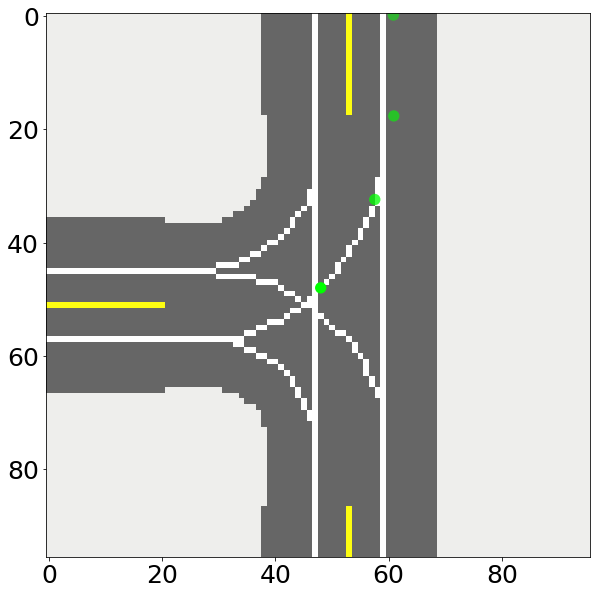

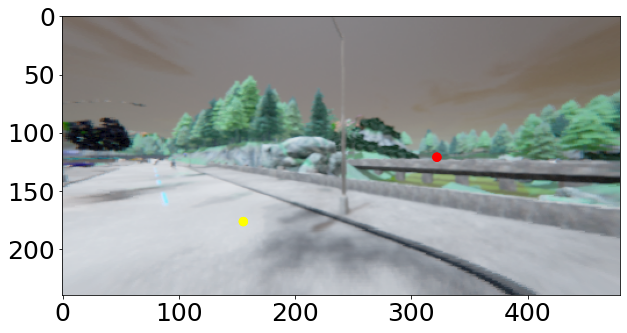

In [151]:
importlib.reload(image_utils)

# Param
MAP_SIZE = 96
N_STEP = 5
GAP = 5
N_DATASET_CATEGORIES = len(data_dict_base.keys())+2
PIXELS_PER_METER = 4

# Waypoints driver perspective

np.set_printoptions(suppress=True)

N = int((len(rep)-1)/N_DATASET_CATEGORIES -1)
print(f'Num frames: {N}')
folder='/storage2/mwildi/CBS2/Notebooks/frames'


frame = 100
tgt_rgb_loc, tgt_bev_loc, cac = loc_frame(rep,frame)
step_data = decode_step(dataset=rep, step=frame)
lbl=step_data['lbl']
cam_pos = step_data['cam_location']
cam_rot = step_data['cam_rotation']
rgb = step_data['wide_rgb_0']
loc=step_data['loc']
print(loc)
print('Finished')

fbev, axbev = plt.subplots(figsize=(10,10))
axbev.imshow(viz_bv(lbl))
#locs_bv2 = conv.world_to_map(loc_world)
#print(locs_bv2)
for i in range(tgt_bev_loc.shape[0]-1):   
    axbev.add_patch(Circle(tgt_bev_loc[i], 1, facecolor=(0,1,0,3/(i+3))))

frgb, axrgb = plt.subplots(figsize=(10,10))
axrgb.imshow(rgb)
#loc_rgb = conv.map_to_cam(loc_bv)
#loc_rgb_direct = conv.world_to_cam(loctorch)
#print(loc_rgb)
#image_coords = convcbs.convert(np.array([[loc[0], loc[1], loc[2]]]))
#print(image_coords) 
step_data_next = decode_step(dataset=rep, step=frame+10)
loc_next=step_data_next['loc']

sensor_transform = Transform(Location(cam_pos[0], cam_pos[1], cam_pos[2]), Rotation(cam_rot[0], cam_rot[1], cam_rot[2]))
converter = image_utils.CoordinateConverter(sensor_transform, fov=120)
conv= worconverter.Converter(offset=6.0, scale=[1.5, 1.5]).to('cpu')

pred = converter.convert(np.array([[loc_next[0], loc_next[1], loc_next[2]]]))
predwor = conv.world_to_cam(torch.tensor(loc_next[:2])).numpy()
pred=pred[0]
predwor=predwor
print('HEy')   
print(predwor)
for i in range(tgt_rgb_loc.shape[0]):   
    #axrgb.add_patch(Circle(tgt_rgb_loc[i], 4, facecolor=(0,1,0,3/(i+3))))
    #axrgb.add_patch(Circle(cac[i], 4, facecolor=(0,1,1,3/(i+3))))
    axrgb.add_patch(Circle(np.array([pred[0], pred[1]]), 4, facecolor=(1,1,0,3/(i+3))))
    axrgb.add_patch(Circle(np.array([predwor[0], predwor[1]]), 4, facecolor=(1,0,0,3/(i+3))))

print(loc_next)
#print(pred)
#print(predwor)
print(converter.unproject(np.array([[pred[0], pred[1]]])))
#print(conv.cam_to_world(torch.tensor([[pred[0], pred[1]]])))

In [107]:
# Param
MAP_SIZE = 96
N_STEP = 5
GAP = 5
N_DATASET_CATEGORIES = len(data_dict_base.keys())+2
PIXELS_PER_METER = 4

# Waypoints driver perspective

np.set_printoptions(suppress=True)

# cam_x = 1.5
# cam_y = 0
# cam_z = 2.4
# cam_yaw = 0
# cam_roll = 0
# cam_pitch = 0

N = int((len(rep)-1)/N_DATASET_CATEGORIES -1)
print(f'Num frames: {N}')
folder='/storage2/mwildi/CBS2/Notebooks/frames'

all_wp = []
all_dloc = []
frame_range = range((N-1) - N_STEP*GAP + 1)
START_FRAME = 930
frame_range = range(START_FRAME, (N-1) - N_STEP*GAP + 1)
for frame in frame_range:
    tgt_rgb_loc, tgt_bev_loc = loc_frame(rep,frame)
    all_wp.append(tgt_rgb_loc)
    all_dloc.append(tgt_bev_loc)
print('Finished')

Num frames: 999
940
[159.159       -0.9574204    0.03300434]
CBS: [194.98020651 202.79480093   3.99527657]
WoR: [239.1474  122.26678]
945
[156.32124      1.4451362    0.03335979]
CBS: [161.37619953 168.93382124   6.72911272]
WoR: [241.30862 122.30499]


ValueError: too many values to unpack (expected 2)

In [ ]:
#os.chdir(folder)
folder='/storage2/mwildi/CBS2/Notebooks/frames'
for i in frame_range:
    bev = cv2.imread(f'{folder}/bev{i}.png')
    rgb = cv2.imread(f'{folder}/rgb{i}.png')
    if rgb is not None and bev is not None:
        f, [rgb_ax, lbl_ax] = plt.subplots(1,2, figsize=(40,20))
        rgb_ax.imshow(cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
        #lbl_ax.imshow(cv2.cvtColor(np.rot90(np.rot90(np.rot90(bev))), cv2.COLOR_RGB2BGR))
        lbl_ax.imshow(cv2.cvtColor(bev, cv2.COLOR_RGB2BGR))
        rgb_ax.axis('off')
        lbl_ax.axis('off')
        plt.savefig(folder + "/mix%d.png" % i)
        plt.close()

In [ ]:
img_array=[]
for i in frame_range:
    img = cv2.imread(f'{folder}/mix{i}.png')
    if img is not None:
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
out = cv2.VideoWriter('projeceet.mp4',0x7634706d, 5, size)
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [1]:
from pathlib import Path
import torch
import lmdb
import os
import glob
import numpy as np
import cv2
import math
import random

PIXEL_OFFSET = 10
N_TRAFFIC_LIGHT_STATES = 1
SEG_CLASSES = {4, 6, 7, 10, 18}  # pedestrians, roadlines, roads, vehicles, tl


buffer = 40
n_step = 5
gap= 5
ori_gap = 5

def project_vehicle(converter, x, y, z, ori_x, ori_y, ori_z):
    pos = np.array([x, y, z])
    ori = np.array([ori_x, ori_y, ori_z])
    ori /= np.linalg.norm(ori)  # Make unit vector

    #new_pos = pos + 4 * ori
    fwd_2d_angle = np.deg2rad(ori_y) #yaw to rad
    new_pos = pos + 5.5 * np.array([np.cos(fwd_2d_angle), np.sin(fwd_2d_angle), 0])
    new_pos_cam_coords = converter.convert(np.array([new_pos]))
    if(new_pos_cam_coords.shape[0] == 0):
        return np.array([[192, 147, 0]]) # In the center of the image, almost at the bottom --> stop waypoint
    return new_pos_cam_coords


def interpolate_waypoints(points):
    points = points[:, :2]

    # Fit first or second function through points
    n_degree = 2 if points.shape[0] > 2 else 1
    z = np.polyfit(points[:, 0], points[:, 1], n_degree)
    p = np.poly1d(z)

    # Keep interpolating until we have n_step points
    while points.shape[0] < 5:
        points_2 = np.vstack([points[0], points[:-1]])
        max_id = np.argmax(np.linalg.norm(points - points_2, axis=1))
        _x = np.mean([points[max_id], points_2[max_id]], axis=0)[0]
        points = np.insert(points, max_id, np.array([_x, p(_x)]), 0)

    return points

def get_waypoints(converter, index, lmdb_txn, world_x, world_y, world_z, ori_x, ori_y, ori_z):
    tl = int.from_bytes(lmdb_txn.get(('trafficlights_%04d' % index).encode()), 'little')

    output = []
    #if tl or vehicle or walker:
    if tl:
        vehicle_proj = project_vehicle(converter, world_x, world_y, world_z, ori_x, ori_y, ori_z)
        output = np.array([vehicle_proj[0] for _ in range(n_step)])
        return output, 3 # Traffic light --> stop

    for i in range(index, (index + (n_step + 1 + buffer * gap)), gap):
        if len(output) == n_step:
            break

        x, y, z = np.frombuffer(lmdb_txn.get(('loc_%04d' % i).encode()), np.float32)
        image_coords = converter.convert(np.array([[x, y, z]]))
        if len(image_coords) > 0:
            output.append(image_coords[0])

    if len(output) < 2:
        # First try with smaller GAP
        if gap == ori_gap:
            gap = 1
            return get_waypoints(converter, index, lmdb_txn, world_x, world_y, world_z,ori_x, ori_y, ori_z)

        vehicle_proj = project_vehicle(converter, world_x, world_y, world_z, ori_x,ori_y, ori_z)
        output = np.array([vehicle_proj[0] for _ in range(n_step)])
        #return output, True
        return output, 2 # Less than two waypoints --> stop

    if 2 <= len(output) < n_step:
        return interpolate_waypoints(converter, np.array(output)), 1 # Interpolation
    #return np.array(output), False
    return np.array(output), 0 # All waypoints ok

In [ ]:
get_waypoints(